# Automatic BSPF AnalysisData

Creates automatic event plots based on catalog 

In [6]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from pprint import pprint

from functions.request_data import __request_data
from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth
from functions.compute_adr_pfo import __compute_adr_pfo


In [7]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [8]:
def __process_xpfo(config, st, inv):

    ii_pfo = st.copy()

#     pre_filt = [0.005, 0.01, 19, 20]

    ## cut properly
#     ii_pfo.trim(config['tbeg'], config['tend'])

    ## demean
    ii_pfo.detrend("demean")

    ## remove response
#     ii_pfo.remove_response(inventory=inv, 
#     #                        pre_filt=pre_filt, 
#                            output="VEL",
#     #                        water_level=60, 
#                            plot=False)

    ## taper 
    ii_pfo.taper(0.1)

    ## bandpass
    ii_filter = ii_pfo.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

    ## adjust channel names
    for tr in ii_pfo:
        if tr.stats.channel[-1] == "1":
            tr.stats.channel = str(tr.stats.channel).replace("1","N")
        if tr.stats.channel[-1] == "2":
            tr.stats.channel = str(tr.stats.channel).replace("2","E")
    
    return ii_pfo

In [9]:
def __makeplot(config, st):

    
    st_in = st.copy()
    
    fig, ax = plt.subplots(6,1, figsize=(15,10), sharex=True)

    font = 14

    time_scaling, time_unit = 1, "sec"
    rot_scaling = 1e9
    trans_scaling = 1e6
    
    for i, tr in enumerate(st_in):
        
        if i in [0,1,2]:
            ax[i].set_ylabel(r"$\omega$ (nrad/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*rot_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)

        elif i in [3,4,5]:
            ax[i].set_ylabel(r"u ($\mu$m/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*trans_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)
            
        ax[i].legend(loc=1)
        
    ax[5].set_xlabel(f"Time ({time_unit}) from {st[0].stats.starttime.date} {str(st[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font)
    ax[0].set_title(config['title']+f" | {config['fmin']} - {config['fmax']} Hz", fontsize=font, pad=10)
    
    plt.show();
    del st_in
    return fig

In [10]:
def __makeplotStreamSpectra2(st, config, fscale=None):

    from scipy import fftpack
    from andbro__fft import __fft
    import matplotlib.pyplot as plt

    st_in = st.copy()
    
    NN = len(st_in)
    rot_scaling, rot_unit = 1e9, r"nrad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"
        
    fig, axes = plt.subplots(NN,2,figsize=(15,int(NN*2)), sharex='col')

    font = 14
    
    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    for i, tr in enumerate(st_in):

#         comp_fft = abs(fftpack.fft(tr.data))
#         ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
#         comp_fft = fftpack.fftshift(comp_fft)
#         ff, spec = ff[1:len(ff)//2], abs(fftpack.fft(tr.data)[1:len(ff)//2])

        if tr.stats.channel[-2] == "J":
            scaling = rot_scaling
        elif tr.stats.channel[-2] == "H":
            scaling = trans_scaling

        spec, ff, ph = __fft(tr.data*scaling, tr.stats.delta, window=None, normalize=None)
    
    
        ## _________________________________________________________________
        if tr.stats.channel[-2] == "J":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*rot_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )

        elif tr.stats.channel[-2] == "H":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*trans_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )
        ## _________________________________________________________________
        if fscale == "loglog":
            axes[i,1].loglog(ff, spec, color='black', lw=1.0)
        elif fscale == "loglin":
            axes[i,1].semilogx(ff, spec, color='black', lw=1.0)
        elif fscale == "linlog":
            axes[i,1].semilogy(ff, spec, color='black', lw=1.0)
        else:
            axes[i,1].plot(ff, spec, color='black', lw=1.0)         
        
        
        if tr.stats.channel[1] == "J":
            sym, unit = r"$\Omega$", rot_unit
        elif tr.stats.channel[1] == "H":
            sym, unit = "v", trans_unit
        else:
            unit = "Amplitude", "a.u."
            
        axes[i,0].set_ylabel(f'{sym} ({unit})',fontsize=font)    
        axes[i,1].set_ylabel(f'ASD \n({unit}/Hz)',fontsize=font)        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
        
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    if "fmin" in config.keys() and "fmax" in config.keys():
        axes[i,1].set_xlim(config['fmin'],config['fmax'])

    axes[NN-1,0].set_xlabel(f"Time from {tr.stats.starttime.date} {str(tr.stats.starttime.time)[:8]} (s)",fontsize=font)     
    axes[NN-1,1].set_xlabel(f"Frequency (Hz)",fontsize=font)     

    del st_in
    return fig

In [11]:
def __empty_stream(reference_stream):

    from numpy import ones
    from obspy import Stream, Trace
    
    t_ref = reference_stream[0]
    
    empty = Stream()

    for cha in ["BHZ", "BHN", "BHE"]:
        t = Trace()
        t.data = ones(len(t_ref))
        t.stats.sampling_rate = t_ref.stats.sampling_rate
        t.stats.starttime = t_ref.stats.starttime
        t.stats.network, t.stats.station, t.stats.channel = "PY", "RPFO", cha
        empty += t
        
    return empty

In [12]:
def __stream_to_dataframe(st):
    
    dff = pd.DataFrame()

    for tr in st: 
        name = f"{tr.stats.station}_{tr.stats.location}_{tr.stats.channel}"
        dff[name] = tr.data
        
    return dff

## Configurations

In [13]:
config = {}

## location of BSPF
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

## path for figures to store
# config['outpath_figs'] = data_path+"BSPF/figures/triggered_all/"

## path for output data
config['outpath_data'] = data_path+"BSPF/data/" 

config['path_to_mseed'] = data_path+"BSPF/data/waveforms/" 

## blueSeis sensor (@200Hz)
# config['seed_blueseis'] = "PY.BSPF..HJ*"

## Trillium 240 next to BlueSeis on Pier (@40Hz)
# config['seed_seismometer1'] = "II.PFO.10.BH*" 

## STS2 next to BlueSeis (@200Hz)
# config['seed_seismometer2'] = "PY.PFOIX..HH*" 

config['path_to_catalog'] = data_path+"BSPF/data/catalogs/"

config['catalog'] = "BSPF_catalog_20221001_20230615_triggered.pkl"

## Event Info

In [14]:
events = pd.read_pickle(config['path_to_catalog']+config['catalog'])

## add column for hypocenter distance
events['Hdistance_km'] = np.sqrt(events['distances_km']**2+(events['depth']/1000)**2)
events

origin   latitude   longitude    depth  magnitude type  \
0   2022-10-01 05:36:11.240  33.489667 -116.507167   9120.0       1.13   ml   
1   2022-10-01 21:26:43.530  33.978000 -116.730500  15130.0       2.08   ml   
2   2022-10-02 03:25:16.440  33.484333 -116.508500   8040.0       1.49   ml   
3   2022-10-02 15:51:37.180  33.480167 -116.398000   8240.0       1.68   ml   
4   2022-10-02 21:52:54.280  33.485333 -116.509333   9650.0       0.99   ml   
..                      ...        ...         ...      ...        ...  ...   
277 2023-06-05 17:22:59.900  33.992667 -116.609167  15140.0       0.91   ml   
278 2023-06-05 17:23:05.920  33.992667 -116.612500  14750.0       1.95   ml   
279 2023-06-07 06:03:42.030  33.965667 -116.946000   7240.0       2.58   ml   
280 2023-06-11 02:38:25.290  33.604000 -116.628000  13450.0       1.12   ml   
281 2023-06-11 03:32:26.760  33.523667 -116.525000  12760.0       0.81   ml   

         seconds                 trigger_time                 arrival_time  \
0       20171.24  2022-10-01T05:36:10.344538Z  2022-10-01T05:36:15.816780Z   
1       77203.53  2022-10-01T21:26:51.694538Z  2022-10-01T21:26:55.332138Z   
2       98716.44  2022-10-02T03:25:19.269538Z  2022-10-02T03:25:20.869968Z   
3      143497.18  2022-10-02T15:51:37.444539Z  2022-10-02T15:51:41.755137Z   
4      165174.28  2022-10-02T21:52:57.394539Z  2022-10-02T21:52:59.069507Z   
..           ...                          ...                          ...   
277  21403379.90  2023-06-05T17:23:13.670000Z  2023-06-05T17:23:11.132115Z   
278  21403385.92  2023-06-05T17:23:13.670000Z  2023-06-05T17:23:17.078772Z   
279  21535422.03  2023-06-07T06:03:52.040000Z  2023-06-07T06:03:54.073220Z   
280  21868705.29  2023-06-11T02:38:28.860000Z  2023-06-11T02:38:31.166238Z   
281  21871946.76  2023-06-11T03:32:29.255000Z  2023-06-11T03:32:31.721943Z   

                      event_time  cosum  backazimuth  distances_km  \
0    2022-10-01T05:36:11.240000Z    4.0    19.684030     14.252022   
1    2022-10-01T21:26:43.530000Z    6.0   147.912150     48.053535   
2    2022-10-02T03:25:16.440000Z    6.0    19.364710     14.850966   
3    2022-10-02T15:51:37.180000Z    6.0   339.780826     15.423592   
4    2022-10-02T21:52:54.280000Z    6.0    19.790278     14.772415   
..                           ...    ...          ...           ...   
277  2023-06-05T17:22:59.900000Z    4.0   161.387898     44.700753   
278  2023-06-05T17:23:05.920000Z    4.0   161.012766     44.800001   
279  2023-06-07T06:03:42.030000Z    6.0   130.780515     60.123060   
280  2023-06-11T02:38:25.290000Z    6.0    87.318065     16.031930   
281  2023-06-11T03:32:26.760000Z    4.0    33.783751     11.609453   

     Hdistance_km  
0       16.920240  
1       50.379154  
2       16.887652  
3       17.486703  
4       17.645021  
..            ...  
277     47.195094  
278     47.165693  
279     60.557410  
280     20.926665  
281     17.251000  

[282 rows x 14 columns]

## RUN LOOP

In [15]:
def __compute_Amax(st_in, out_lst):
     
    st_in = st_in.sort()

    st_in = st_in.detrend("linear")
    
    out, header = [], []
    for tr in st_in:
        out.append(max(abs(tr.data)))
        
        if tr.stats.station[:3] == "PFO":
            header.append(f"PFO_{tr.stats.location}_{tr.stats.channel[-1]}_amax")
        else:
            header.append(f"{tr.stats.station}_{tr.stats.location}_{tr.stats.channel[-1]}_amax")
        
    out_lst.append(out)
    return out_lst, header

In [16]:
def __compute_SNR(st_in, out_lst, trigger_time, win_length_sec=10, plot=False):

    from numpy import nanmean, sqrt
    from obspy import UTCDateTime
    
    st_in = st_in.sort()
    
    if plot:
        fig, ax = plt.subplots(len(st_in),1, figsize=(15,15))
    
    out, header = [], []
    for i, tr in enumerate(st_in):

        t_rel_sec = UTCDateTime(trigger_time)-tr.stats.starttime
        
        df = tr.stats.sampling_rate 

        NN = int(df * win_length_sec) ## samples

        t_rel_spl = t_rel_sec*df ## samples

        t_offset = df * 2 ## samples

        noise = nanmean(tr.data[int(t_rel_spl-NN):int(t_rel_spl)]**2)
        signal = nanmean(tr.data[int(t_rel_spl):int(t_rel_spl+NN)]**2)

        out.append(sqrt(signal/noise))
        if tr.stats.station[:3] == "PFO":
            header.append(f"PFO_{tr.stats.location}_{tr.stats.channel[-1]}_snr")
        else:
            header.append(f"{tr.stats.station}_{tr.stats.location}_{tr.stats.channel[-1]}_snr")
            
        if plot:
            ax[i].plot(tr.data)

            ax[i].axvline(t_rel_spl, color="red")
            ax[i].axvline(t_rel_spl+NN, color="red")

            ax[i].axvline(t_rel_spl, color="g")
            ax[i].axvline(t_rel_spl-NN, color="g")
        
    out_lst.append(out)
    
    return out_lst, header

In [30]:
def __compute_adr_max(st_in, out_lst):
     
    st_in = st_in.copy().sort()

    st_in = st_in.detrend("linear")
    
    bspf_i = st_in.select(station="BSPF").copy()
    bspf_a = st_in.select(station="BSPF").copy()
    adr_i = st_in.select(station="RPFO", location="in").copy()
    adr_a = st_in.select(station="RPFO", location="al").copy()
    
    bspf_i = bspf_i.filter("bandpass", freqmin=0.16, freqmax=16.5, corners=4, zerophase=True)
    bspf_a = bspf_a.filter("bandpass", freqmin=0.02, freqmax=1.3, corners=4, zerophase=True)
    
    bspf_i.detrend("linear")
    bspf_a.detrend("linear")
    
    st0 = adr_i
    st0 += adr_a
    st0 += bspf_i
    st0 += bspf_a
    
#     st0.plot(equal_scale=False);
    
    out, header = [], []
    for tr in st0:
        out.append(max(abs(tr.data)))
        
        if tr.stats.station[:3] == "PFO":
            header.append(f"PFO_{tr.stats.location}_{tr.stats.channel[-1]}_amax")
        else:
            header.append(f"{tr.stats.station}_{tr.stats.location}_{tr.stats.channel[-1]}_amax")
        
    out_lst.append(out)
    return out_lst, header

In [24]:
# def __add_radial_and_transverse_channel(st_in, sta, baz):
    
#     from obspy import Trace
#     from obspy.signal.rotate import rotate_ne_rt

#     st_acc = st_in.select(station=sta).copy()
    
#     r_acc, t_acc = rotate_ne_rt(st_acc.select(channel='*N')[0].data, 
#                                 st_acc.select(channel='*E')[0].data,
#                                 baz
#                                 )
    
    
#     tr_r = st_acc[0].copy()
#     tr_r.data = r_acc
#     tr_r.stats.channel = tr_r.stats.channel[:-1]+"R"
    
#     tr_t = st_acc[0].copy()
#     tr_t.data = t_acc
#     tr_t.stats.channel = tr_t.stats.channel[:-1]+"T"
    
#     st_in += tr_r
#     st_in += tr_t
    
#     return st_in

In [25]:
from functions.add_radial_and_transverse_channel import __add_radial_and_transverse_channel

In [26]:
config['mseed_files'] = sorted([file for file in os.listdir(config['path_to_mseed'])])


 -> 1 2022-10-01 21:26:43.530000 


/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


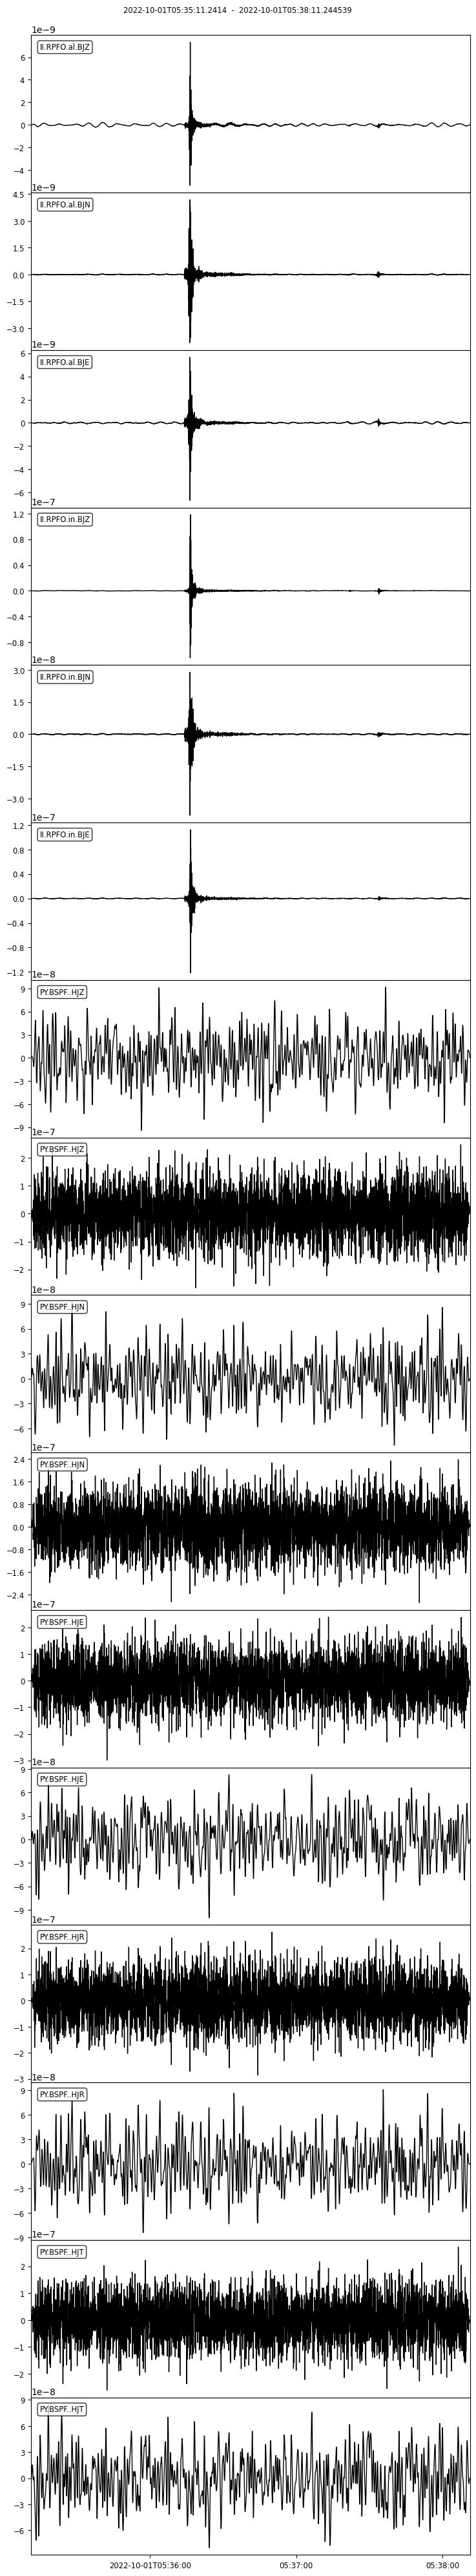


 -> 2 2022-10-02 03:25:16.440000 


/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


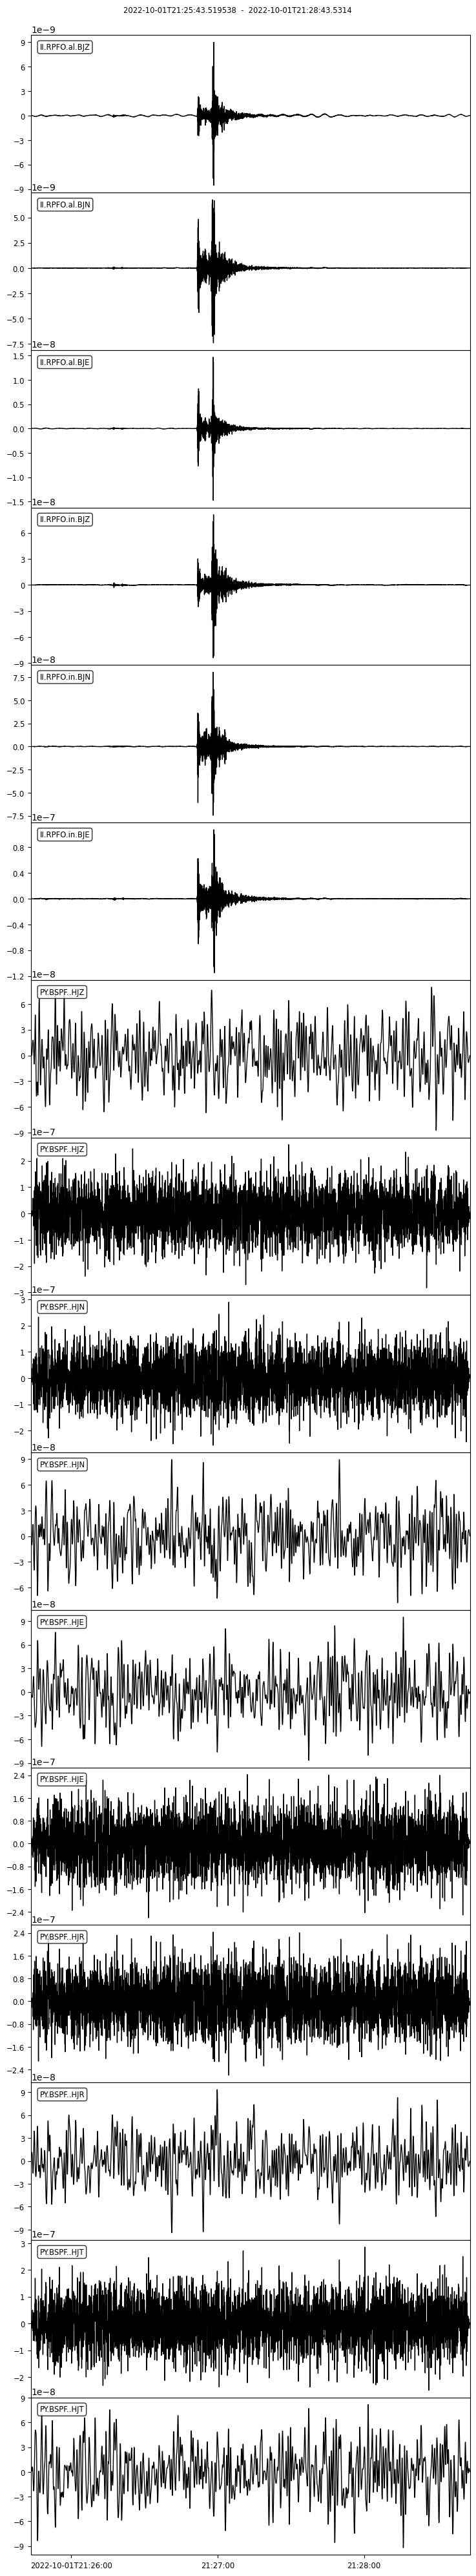


 -> 3 2022-10-02 15:51:37.180000 


/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


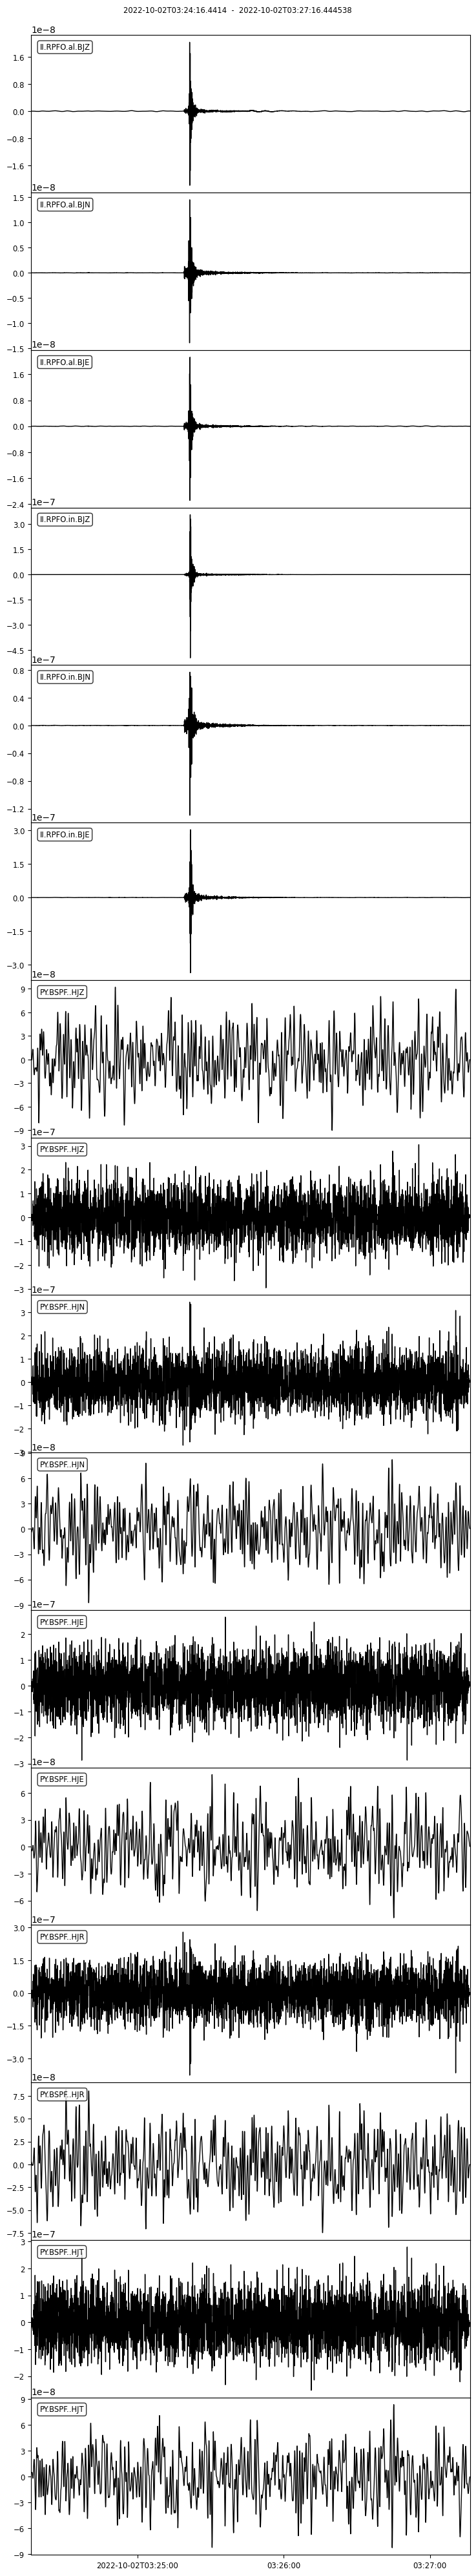


 -> 4 2022-10-02 21:52:54.280000 


/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


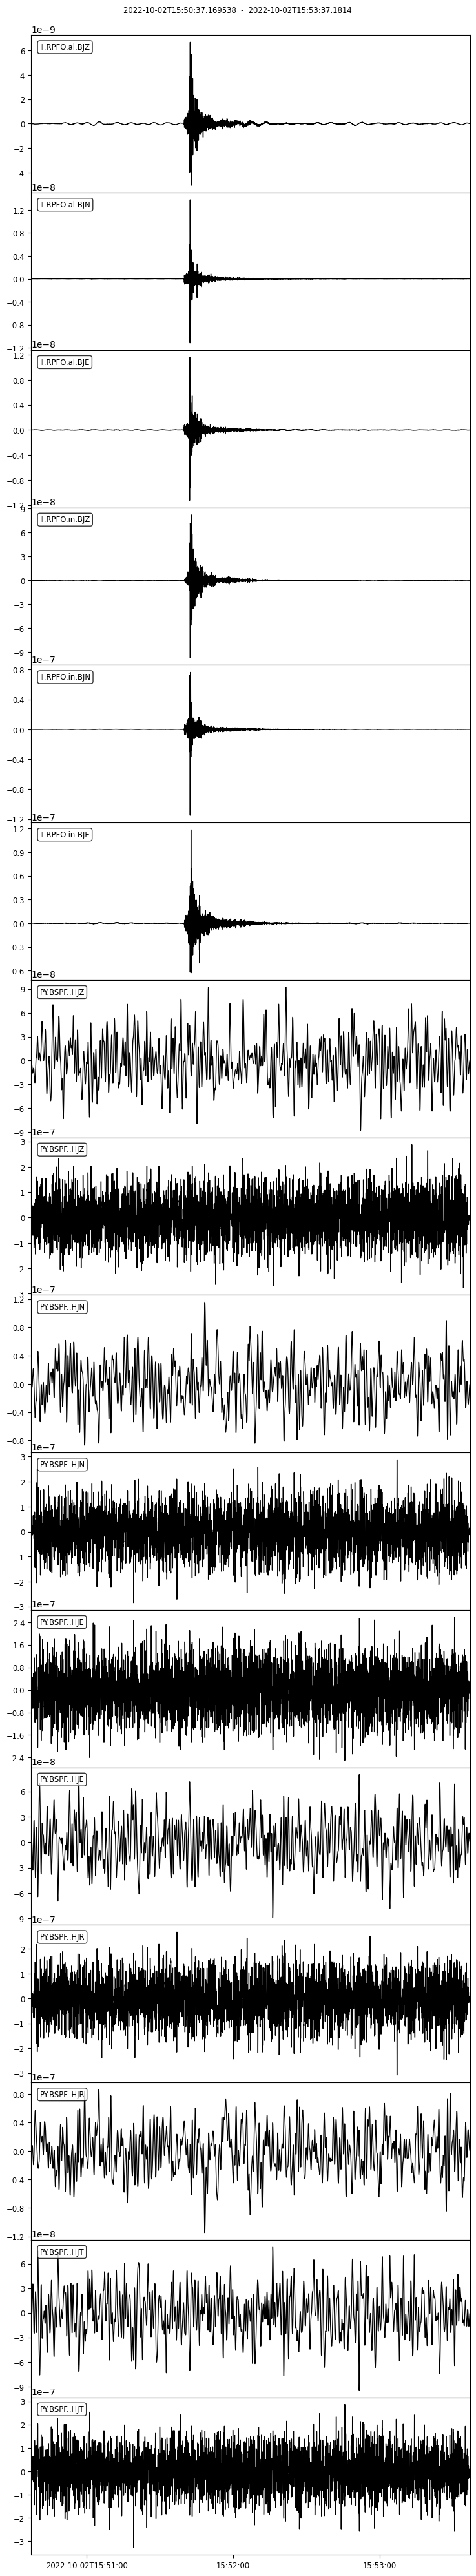


 -> 5 2022-10-03 09:17:36.890000 


/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


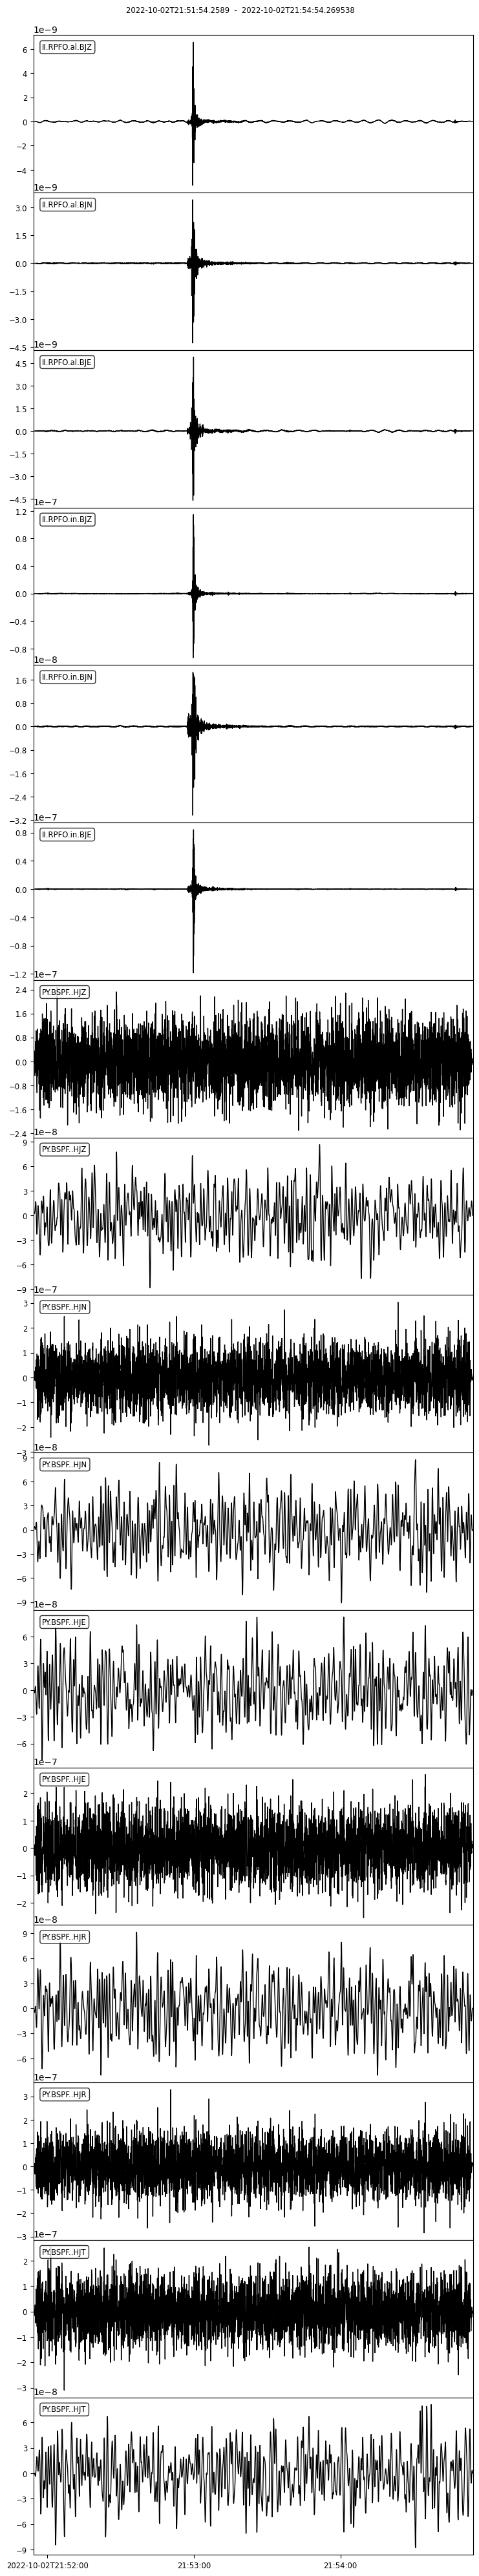


 -> 6 2022-10-03 16:08:09.970000 


/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


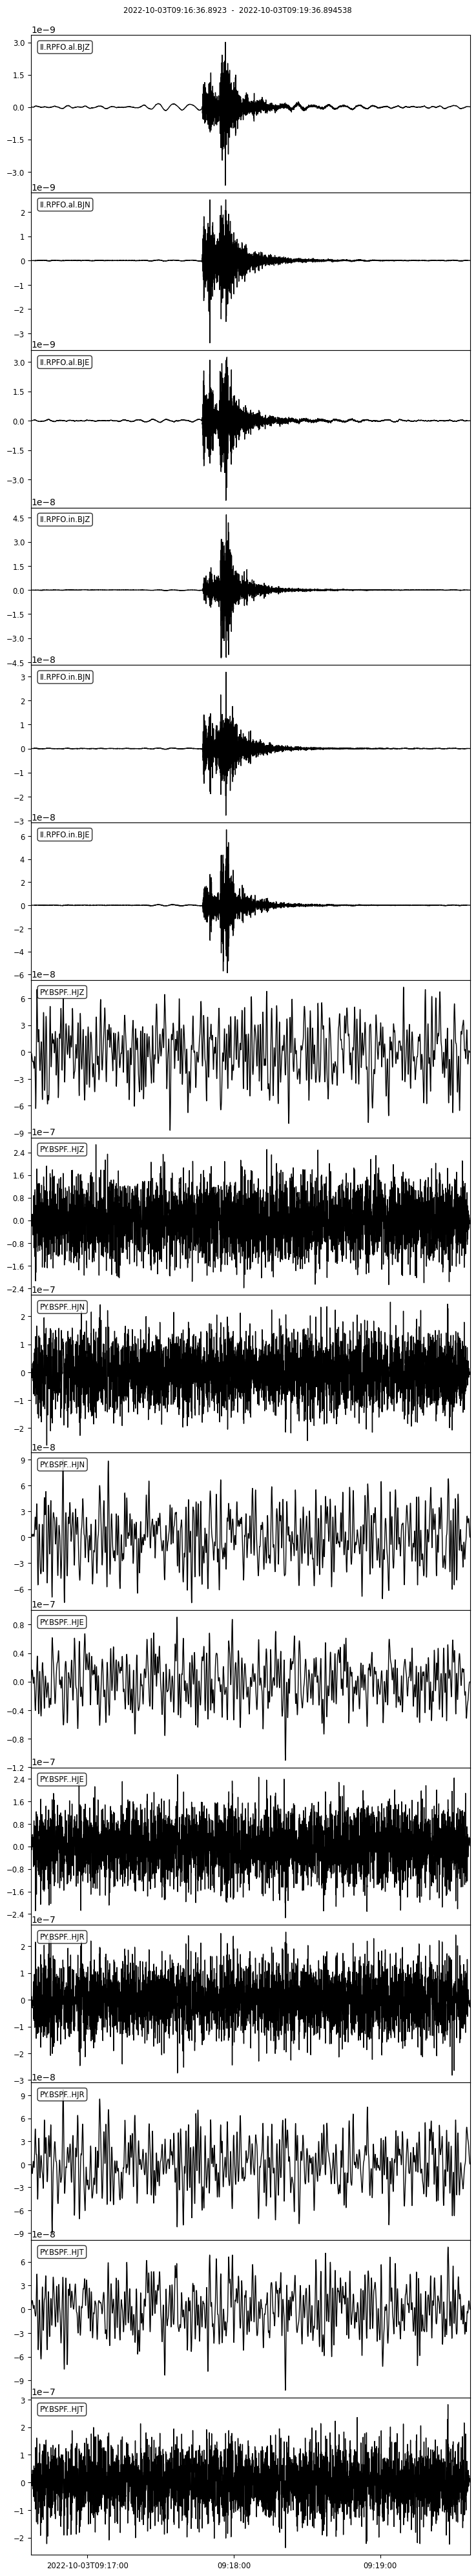


 -> 7 2022-10-04 22:33:48.370000 


/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


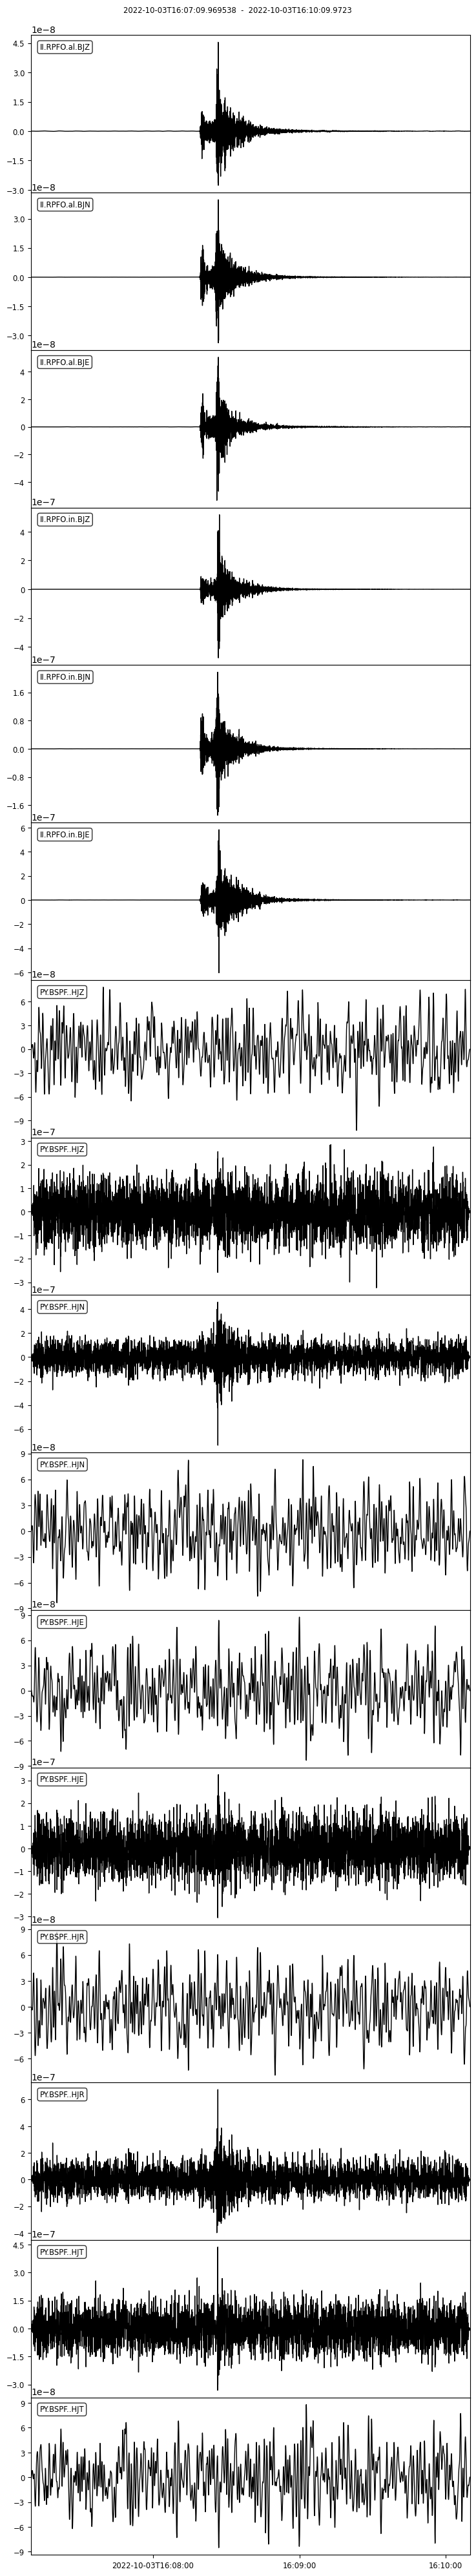


 -> 8 2022-10-05 15:39:32.640000 


/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


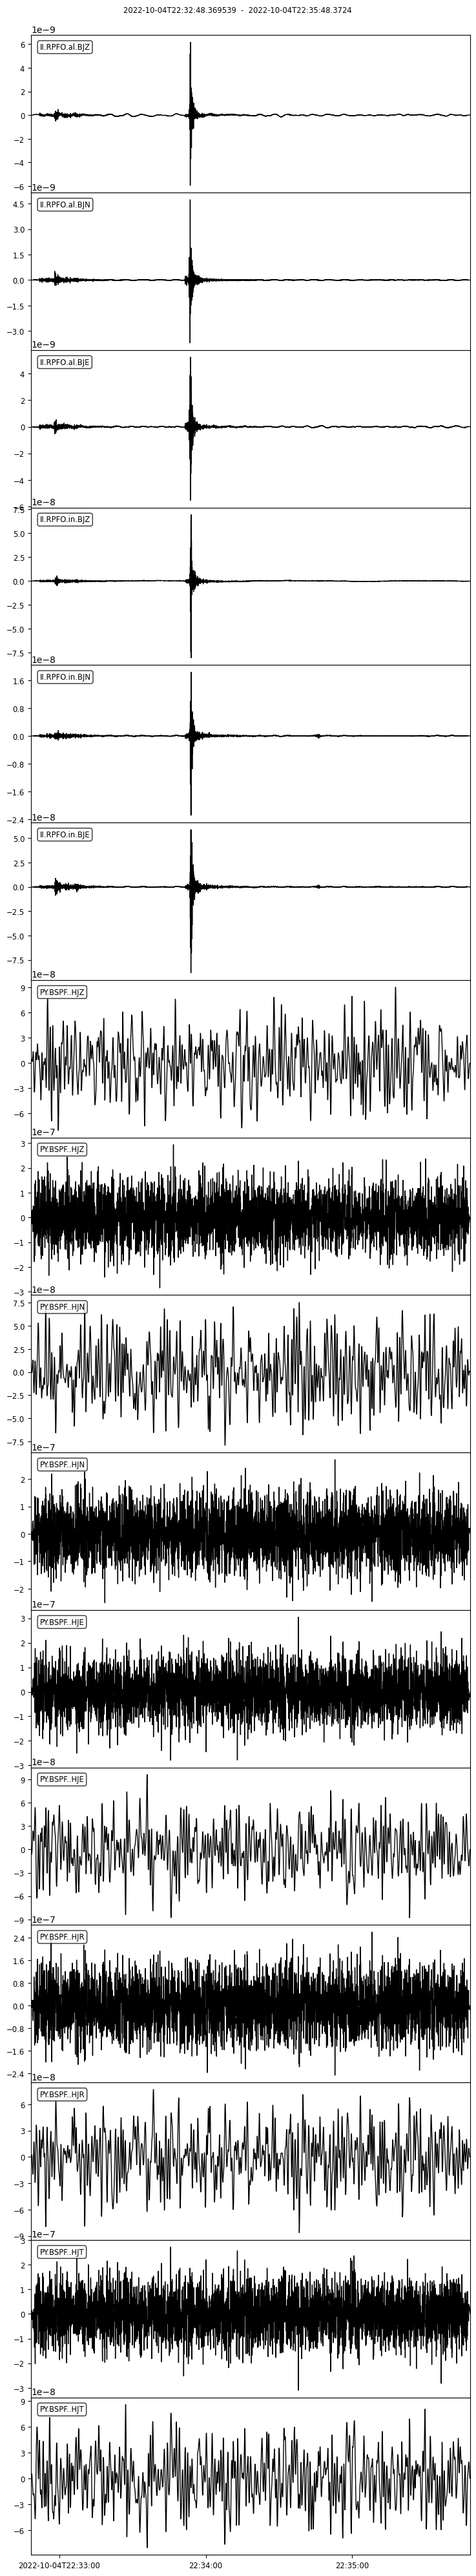


 -> 9 2022-10-07 22:45:05.470000 


/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


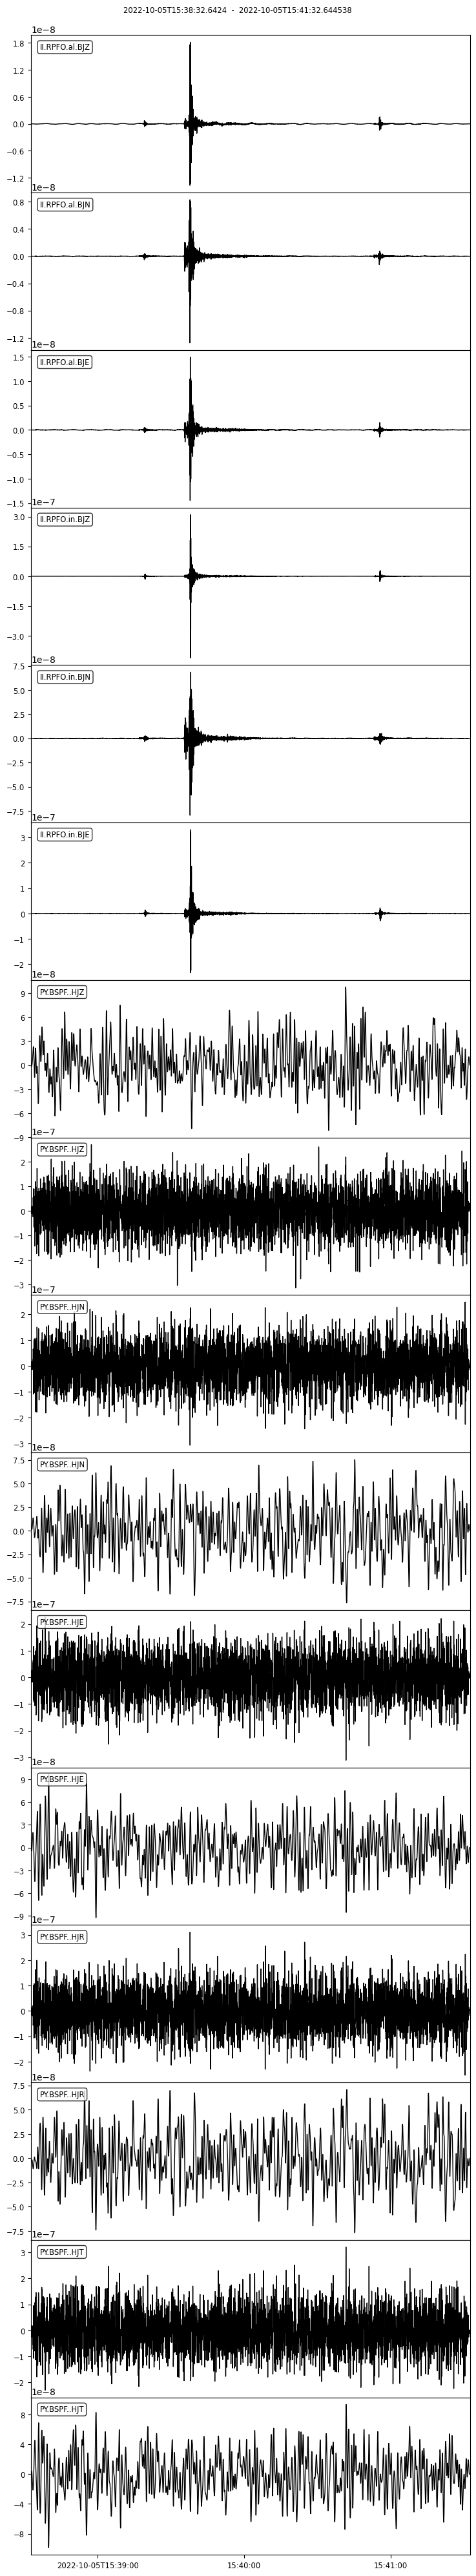


 -> writing: /home/andbro/kilauea-data/BSPF/data/bspf_analysisdata_amax.pkl

 -> writing: /home/andbro/kilauea-data/BSPF/data/bspf_analysisdata_snr.pkl

 -> writing: /home/andbro/kilauea-data/BSPF/data/bspf_analysisdata_adr.pkl

 -> skipped: 1


In [29]:

## create dataframe for output
out_df = pd.DataFrame()

out_df["Torigin"] = events.origin
out_df["Magnitude"] = events.magnitude
out_df["CoincidenceSum"] = events.cosum
out_df["BAZ"] = events.backazimuth
out_df["Edistance"] = events.distances_km
out_df["Hdistance"] = events.Hdistance_km

tmp = [str(ee).split(".")[0] for ee in events.origin]

data_amax, data_snr, data_adr, skipped, jj = [], [], [], 0, 0

for event in config['mseed_files'][:10]:

    yy = int(event.replace(".","_").split("_")[1][:4])
    mm = int(event.replace(".","_").split("_")[1][4:6])
    dd = int(event.replace(".","_").split("_")[1][6:8])
    h = int(event.replace(".","_").split("_")[2][0:2])
    m = int(event.replace(".","_").split("_")[2][2:4])
    s = int(event.replace(".","_").split("_")[2][4:6])

    otime = f"{yy}-{mm:02d}-{dd:02d} {h:02d}:{m:02d}:{s:02d}"
            
    if otime not in tmp:
        skipped += 1
        continue
    else:
        jj += 1
        

    print(f"\n -> {jj} {events.origin[jj]} ")
    
    event_name = str(events.origin[jj]).replace("-","").replace(":","").replace(" ", "_").split(".")[0]
    

    st = obs.read(config['path_to_mseed']+event)

    ## add radial and transverse channels
    st = __add_radial_and_transverse_channel(st, "PFO*", events.backazimuth[jj])
    st = __add_radial_and_transverse_channel(st, "BSPF", events.backazimuth[jj])
    
    
    ## processing data stream
    st = st.detrend("linear")
    st = st.taper(0.01)
    st = st.filter("highpass", freq=0.01, corners=4, zerophase=True)
    
    
    ## compute maximal amplitude values (PGA and PGR)
    data_amax, header_amax = __compute_Amax(st, data_amax)

    ## compute signal-to-noise ratios
    data_snr, header_snr = __compute_SNR(st, data_snr, events.trigger_time[jj], win_length_sec=5)
    
    ## compute signal-to-noise ratios
    data_adr, header_adr = __compute_adr_max(st, data_adr)
    

    
## _______________________________________

df_amax = pd.DataFrame(columns=header_amax)

for i, row in enumerate(data_amax):
    if len(row) == len(st):
        df_amax.loc[len(df_amax)] = row
    else:
        df_amax.loc[len(df_amax)] = np.ones(len(st))*np.nan

df_amax_out = pd.concat([out_df, df_amax], axis=1, ignore_index=False, sort=False)

df_amax_out.to_pickle(config['outpath_data']+"bspf_analysisdata_amax.pkl")
print(f"\n -> writing: {config['outpath_data']}bspf_analysisdata_amax.pkl")

## _______________________________________ 
    
df_snr = pd.DataFrame(columns=header_snr)


for row in data_snr:
    if len(row) == len(st):
        df_snr.loc[len(df_snr)] = row    
    else:
        df_snr.loc[len(df_snr)] = np.ones(len(st))*np.nan

df_snr_out = pd.concat([out_df, df_snr], axis=1, ignore_index=False, sort=False)

df_snr_out.to_pickle(config['outpath_data']+"bspf_analysisdata_snr.pkl")
print(f"\n -> writing: {config['outpath_data']}bspf_analysisdata_snr.pkl")

## _______________________________________

df_adr = pd.DataFrame(columns=header_adr)

for i, row in enumerate(data_adr):
    if len(row) == len(st):
        df_adr.loc[len(df_adr)] = row
    else:
        df_adr.loc[len(df_adr)] = np.ones(len(st))*np.nan

df_adr_out = pd.concat([out_df, df_adr], axis=1, ignore_index=False, sort=False)

df_adr_out.to_pickle(config['outpath_data']+"bspf_analysisdata_adr.pkl")
print(f"\n -> writing: {config['outpath_data']}bspf_analysisdata_adr.pkl")



print(f"\n -> skipped: {skipped}")

## End of File

## Testing Signal-to-Noise ratios

In [98]:
# from numpy import nanmean, sqrt

# win_length_sec = 10 ## seconds

# t_trigger = events.trigger_time[jj]
# t_rel_sec = t_trigger-config['tbeg']
# fig, ax = plt.subplots(len(st0),1, figsize=(15,15))

# for i, tr in enumerate(st0):
    
#     df = tr.stats.sampling_rate 
    
#     NN = int(df * win_length_sec) ## samples
    
#     t_rel_spl = t_rel_sec*df ## samples
    
#     t_offset = df * 2 ## samples
    
#     noise = nanmean(tr.data[int(t_rel_spl-NN):int(t_rel_spl)]**2)
#     signal = nanmean(tr.data[int(t_rel_spl):int(t_rel_spl+NN)]**2)
    
#     SNR = sqrt(signal/noise)
    
    
       
#     ax[i].plot(tr.data)
    
#     ax[i].axvline(t_rel_spl, color="red")
#     ax[i].axvline(t_rel_spl+NN, color="red")

#     ax[i].axvline(t_rel_spl, color="g")
#     ax[i].axvline(t_rel_spl-NN, color="g")

#     print(SNR)
    
# plt.show();    


## CC for f-bands

In [201]:
def __cc_in_octaves(st_in, fmin, fmax):

    from pandas import DataFrame
    from functions.get_octave_bands import __get_octave_bands
    from functions.compute_cc_for_fbands import __compute_cc_for_fbands
    
    flower, fupper, fcenter = __get_octave_bands(fmin, fmax, fband_type="one-third-octave")

    fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

    ## _____________________

#     fbands = [(1,5),(2,6),(3,7),(4,8),(5,9),(6,10),(7,11),(8,12),(9,13),(10,14),(11,15),(12,16),(13,17),(14,18)]
#     fbands = [(1,2),(2,4),(3,6),(4,8),(5,10),(6,12),(7,14),(8,16), (9,18), (10,20)]

    df_out = DataFrame()
    
    for comp in ["Z","N","E"]:

        print(comp)

        plt.figure(figsize=(15,5))

        tr1 = st_in.select(station="BSPF", channel=f'*{comp}')[0]
        tr2 = st_in.select(station="RPFO", location="in", channel=f'*{comp}')[0]
        tr3 = st_in.select(station="RPFO", location="al", channel=f'*{comp}')[0]
        
        
        ff, cc_t_max, cc_f_max = __compute_cc_for_fbands(tr1, tr2, fbands=fbands, plot=False)
        
        df_out[f'{comp}_in_fband'] = ff
        df_out[f'{comp}_in_cc_t'] = cc_t_max
        df_out[f'{comp}_in_cc_f'] = cc_f_max
        
        plt.scatter(ff, cc_t_max, color="r")
        plt.scatter(ff, cc_f_max, color="r")

        ff, cc_t_max, cc_f_max = __compute_cc_for_fbands(tr1, tr3, fbands=fbands, plot=False)

        df_out[f'{comp}_al_fband'] = ff
        df_out[f'{comp}_al_cc_t'] = cc_t_max
        df_out[f'{comp}_al_cc_f'] = cc_f_max
        
        plt.scatter(ff, cc_t_max)
        plt.scatter(ff, cc_f_max) 

    #     plt.xscale("log")
        plt.show()
        
    return df_out

In [596]:
# def __coherence_in_octaves(st_in, fmin, fmax):

#     from numpy import arange, mean
#     from pandas import DataFrame
#     from functions.get_octave_bands import __get_octave_bands
#     from scipy.signal import coherence
    
#     flower, fupper, fcenter = __get_octave_bands(fmin, fmax, fband_type="one-third-octave")
#     fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

#     ## _____________________

# #     ddf = 3
# #     fcenter = arange(fmin+ddf, fmax-ddf, 1)
# #     fbands = [(fc - ddf, fc + ddf) for fc in fcenter] 
    
#     df_out = DataFrame()
    
#     fig, ax = plt.subplots(1,3,figsize=(15,5))
    
#     for ii, comp in enumerate(["Z","N","E"]):

#         tr1 = st_in.select(station="BSPF", channel=f'*{comp}')[0]
#         tr2 = st_in.select(station="RPFO", location="in", channel=f'*{comp}')[0]
#         tr3 = st_in.select(station="RPFO", location="al", channel=f'*{comp}')[0]
        
#         co2, co3 = [],[]
#         for (fl, fu) in fbands:
#             s1, s2, s3 = tr1.copy(), tr2.copy(), tr3.copy()
            
#             s1 = s1.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
#             s2 = s2.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
#             s3 = s3.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
            
#             s1 = s1.normalize()
#             s2 = s2.normalize()
#             s3 = s3.normalize()

#             s1 = s1.taper(0.1)
#             s2 = s2.taper(0.1)
#             s3 = s3.taper(0.1)
            
#             df = s1.stats.sampling_rate
#             tseg = 1/fl*20
#             nseg = int(df*tseg)
            
# #             ff2, coh2 = coherence(s1.data, s2.data, fs=df, window='hann',nperseg=nseg, noverlap=int(0.5*nseg))
# #             ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann',nperseg=nseg, noverlap=int(0.5*nseg))
#             ff2, coh2 = coherence(s1.data, s2.data, fs=df, window='hann')
#             ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann')
        
#             for i in range(len(ff2)):
#                 if ff2[i] < fl or ff2[i] > fu:
#                     coh2[i], coh3[i] = 0, 0
        
# #             plt.figure()
# #             plt.plot(ff2, coh2)
# #             plt.show()
            
#             co2.append(max(coh2))
#             co3.append(max(coh3))
            
#         df_out[f'{comp}_in_fc'] = fcenter
#         df_out[f'{comp}_in_co']  = co2
#         df_out[f'{comp}_al_fc'] = fcenter
#         df_out[f'{comp}_al_co']  = co3
                 
#         ax[ii].scatter(fcenter, co2, s=50, label="BSPF-RPFO_inner")
#         ax[ii].plot(fcenter, co2, ls="-")

#         ax[ii].scatter(fcenter, co3, s=50, label="BSPF-PRFO_all")
#         ax[ii].plot(fcenter, co3, ls="-")

#         ax[ii].set_title(f"max. coherence {comp}")
#         ax[ii].legend()
#         ax[ii].set_xscale("log")
#         ax[ii].grid(ls="--",zorder=0,alpha=.5, which="both")
#     plt.show();
        
#     return df_out

## Manual Selection

In [252]:
date = UTCDateTime("2023-05-20")
events[(events.origin < str((date+86500).date)) & (events.origin > str((date).date))]

index                  origin   latitude   longitude    depth  magnitude  \
251    287 2023-05-20 08:18:16.240  33.382167 -116.906667  12640.0       3.38   
252    288 2023-05-20 08:20:51.820  33.381833 -116.904000  13440.0       2.61   

    type      seconds                 trigger_time  \
251   ml  19988296.24  2023-05-20T08:18:24.570000Z   
252   ml  19988451.82  2023-05-20T08:21:00.140000Z   

                    arrival_time                   event_time  cosum  \
251  2023-05-20T08:18:27.610016Z  2023-05-20T08:18:16.240000Z    6.0   
252  2023-05-20T08:21:03.342305Z  2023-05-20T08:20:51.820000Z    6.0   

     backazimuth  distances_km  Hdistance_km  
251    58.728876     48.993538     50.597790  
252    58.542019     48.800911     50.617808

In [254]:
good_events = [
    "2022-10-03 16:08:09.970",
    "2022-10-07 22:45:05.470",
    "2022-10-15 05:17:34.150",
    "2022-10-23 09:24:58.150",
    "2022-10-26 08:14:35.080",
    "2022-12-31 12:12:26.650",
    "2023-01-09 19:42:56.460",
    "2023-01-11 18:59:20.030",
    "2023-01-15 09:58:54.070",
    "2023-02-01 09:05:02.320",
    "2023-03-01 22:49:03.580",
    "2023-03-24 13:45:13.700",
    "2023-04-10 14:51:00.950",
    "2023-04-17 18:52:36.930",
    "2023-04-26 06:46:58.450",
    "2023-05-03 21:14:20.210",
    "2023-05-20 08:18:16.240",
]

df = pd.DataFrame()
df['origin_time'] = good_events
# df.to_pickle(config['outpath_data']+"event_selection_good.pkl")

In [255]:
from obspy import UTCDateTime

## list of events to reject (manually)
no_event = ["2022-10-05 15:39:13.690", 
            "2022-10-05 15:42:03.610",
            "2022-10-05 18:35:16.860",
            "2022-10-10 05:48:52.890",
            "2022-10-12 19:12:14.670",
            "2022-10-12 23:08:11.410",
            "2022-10-12 23:58:00.800",
            "2022-10-14 03:13:56.380",
            "2022-10-16 08:42:24.970",
            "2022-10-26 08:27:09.860",
            "2022-10-28 12:47:26.910",
            "2022-11-03 05:53:34.230",
            "2022-11-09 00:46:57.550",
            "2022-11-10 16:53:29.940",
            "2022-11-25 10:45:36.390",
            "2022-12-06 21:56:31.330",
            "2022-12-09 06:03:03.220",
            "2022-12-15 13:55:13.460",
            "2022-12-17 18:02:34.910",
            "2022-12-19 15:41:22.380",
            "2022-12-19 15:41:26.020",
            "2023-01-05 09:59:04.210",
            "2023-01-07 12:32:45.250",
            "2023-01-16 00:00:36.100",
            "2023-01-29 23:50:47.770",
            "2023-02-05 23:38:46.670",
            "2023-02-22 05:09:39.970",
            "2023-03-09 11:49:06.640",
            "2023-03-17 07:12:56.970",
            "2023-03-24 13:59:00.160",
            "2023-03-29 19:23:29.470",
            "2023-03-29 19:23:27.460",
            "2023-04-06 02:42:00.600",
            "2023-04-13 23:57:53.950",
            "2023-04-17 15:27:56.450",
            "2023-05-01 02:52:56.160",
            "2023-06-02 20:19:46.740",
            "2023-06-05 07:39:16.650",
           ]

no_event_utc = list(map(UTCDateTime, no_event))


df = pd.DataFrame()
df['origin_time'] = no_event
# df.to_pickle(config['outpath_data']+"event_selection_reject.pkl")